# NBA Data Modeling

The purpose of this notebook is to create several models to predict salary based on key player stats and to compare the different model results.

## Imports and Loading Data

In [1]:
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# model specific imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
# load the train/test data that was pre-processed in a previous notebook
X_train = pd.read_csv('NBA X_train', index_col=0)
X_test = pd.read_csv('NBA X_test', index_col=0)
y_train = pd.read_csv('NBA y_train', index_col=0)
y_test = pd.read_csv('NBA y_test', index_col=0)

# create a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=10)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(178, 75) (60, 75) (80, 75) (178, 1) (60, 1) (80, 1)


In [3]:
# reshape the y data
y_train = y_train['Salary (millions)'].to_numpy()
y_val = y_val['Salary (millions)'].to_numpy()
y_test = y_test['Salary (millions)'].to_numpy()
print(y_train.shape, y_val.shape, y_test.shape)

(178,) (60,) (80,)


In [4]:
# define rmse function

def rmse_func(model, X, y):
    predictions = model.predict(X)
    rmse = np.sqrt(mean_squared_error(predictions, y))
    return(rmse)

# Linear Regression Model

In [5]:
# initiate the linear regression model and fit it to the training data
lm = LinearRegression()
lm.fit(X_train, y_train)

# predict the test set results
y_pred = lm.predict(X_test)

Evaluate the Linear Regression Model

In [6]:
print('The r-squared value is ' + str(r2_score(y_test, y_pred)))
print('The root mean square error is ' + str(rmse_func(lm, X_test, y_test)))
print('The mean absolute error is ' + str(mean_absolute_error(y_pred, y_test)))

The r-squared value is 0.22894305893793243
The root mean square error is 7.700545739636354
The mean absolute error is 6.4134986375


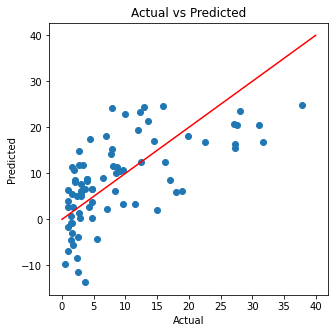

In [7]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred)
plt.plot([0,40], [0,40], 'k-', color='r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

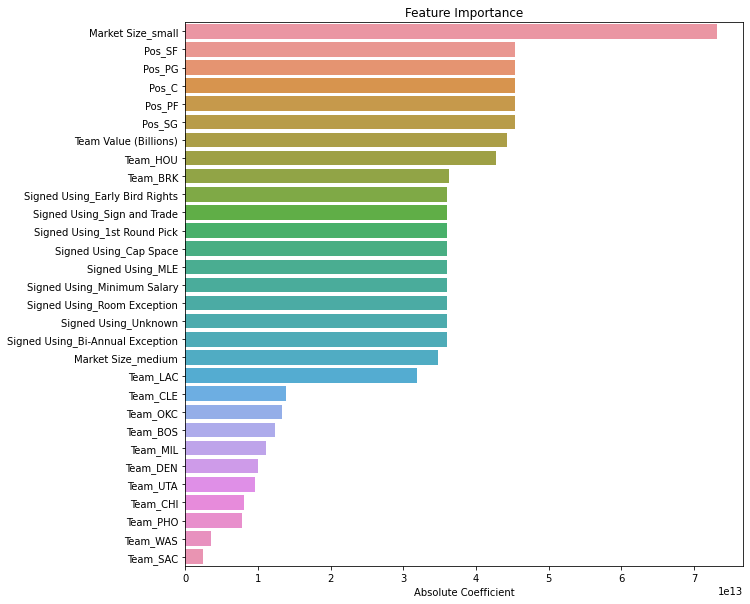

In [8]:
# Determine coefficients and create dataframe
coefs = lm.coef_
columns = X_test.columns
importance = pd.DataFrame({'Absolute Coefficient': coefs})
importance.index = columns

# Sort by coefficient value and transpose
importance = importance.sort_values('Absolute Coefficient', ascending=False)
importance = importance.transpose()

# Define top 30 features
top_30 = importance.iloc[: , :30]

# Create a bar chart to show top 30 features 
plt.figure(figsize=(10,10))
sns.barplot(data=top_30, orient='h')
plt.xlabel('Absolute Coefficient')
plt.title('Feature Importance');

In this first attempt, the r squared value is weak and there are several predicted values below 0, meaning a player would be losing money by playing, which is obviously not true.  Ideally, the actual vs predicted plot points would all be on the red line or very near to it.  In addition, the feature importance plot shows that the model is using team, position, and contract type more than actual player stats to predict salary.

# Ridge Regression

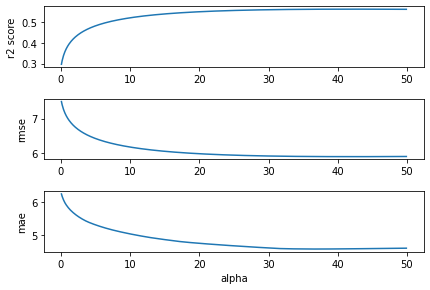

In [9]:
# find optimal alpha value
alphas = np.arange(0.1, 50, 0.1)
r2_scores = []
rmses = []
maes = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_val)
    r2_scores.append(r2_score(y_val, y_pred))
    rmses.append(rmse_func(ridge, X_val, y_val))
    maes.append(mean_absolute_error(y_pred, y_val))
    
fig, ax = plt.subplots(3, 1)
fig.tight_layout()
plt.xlabel('alpha')

ax[0].plot(alphas, r2_scores)
ax[0].set_ylabel('r2 score')

ax[1].plot(alphas, rmses)
ax[1].set_ylabel('rmse')

ax[2].plot(alphas, maes)
ax[2].set_ylabel('mae')

plt.show()

In [10]:
max_r2 = max(r2_scores)
max_index = r2_scores.index(max_r2)
best_alpha_r2 = alphas[max_index]

min_rmse = min(rmses)
min_index = rmses.index(min_rmse)
best_alpha_rmse = alphas[min_index]

min_mae = min(maes)
min_index = maes.index(min_mae)
best_alpha_mae = alphas[min_index]

print(best_alpha_r2, best_alpha_rmse, best_alpha_mae)

42.1 42.1 37.300000000000004


In [11]:
# Initiate and train the model
ridge = Ridge(alpha=42.1)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

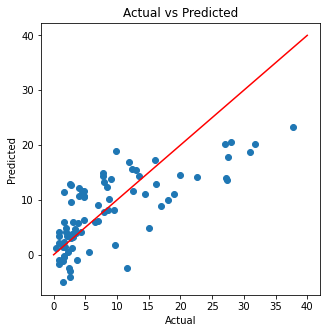

In [12]:
# Visualize the actual vs predicted salaries
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred)
plt.plot([0, 40], [0, 40], 'k-', c='r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [13]:
print('The r squared value is ' + str(r2_score(y_test, y_pred)))
print('The root mean square error is ' + str(rmse_func(ridge, X_test, y_test)))
print('The mean absolute error is ' + str(mean_absolute_error(y_pred, y_test)))

The r squared value is 0.521938489822714
The root mean square error is 6.063455140148374
The mean absolute error is 4.724448583077386


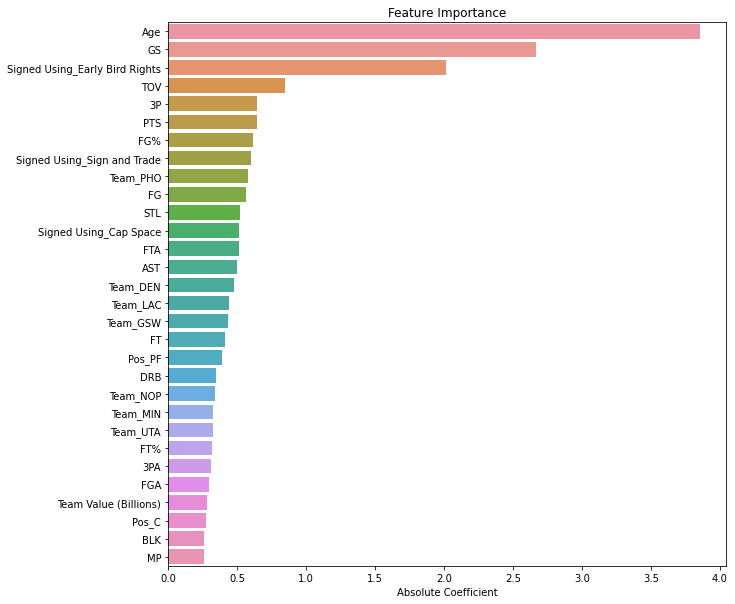

In [14]:
# Determine coefficients and create dataframe
coefs = ridge.coef_
columns = X_test.columns
importance = pd.DataFrame({'Absolute Coefficient': coefs})
importance.index = columns

# Sort by coefficient value and transpose
importance = importance.sort_values('Absolute Coefficient', ascending=False)
importance = importance.transpose()

# Define top 30 features
top_30 = importance.iloc[: , :30]

# Create a bar chart to show top 30 features 
plt.figure(figsize=(10,10))
sns.barplot(data=top_30, orient='h')
plt.xlabel('Absolute Coefficient')
plt.title('Feature Importance');

The Ridge Model is better than the basic linear regression model.  It has much better scoring values (higher r2, lower rmse and mae).  The feature importance plot shows that the ridge model is actually using some of the player stats in combination with team, position, and contract type.  This is an improvement over the basic linear regression model.  The issue of predicting salaries below 0 still exists though.

# Lasso

<ipython-input-15-ad6ce0cecae4>:9: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(X_train, y_train)
C:\Users\Matthew\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\Matthew\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1954.7590224041278, tolerance: 1.8908147070934014
  model = cd_fast.enet_coordinate_descent(


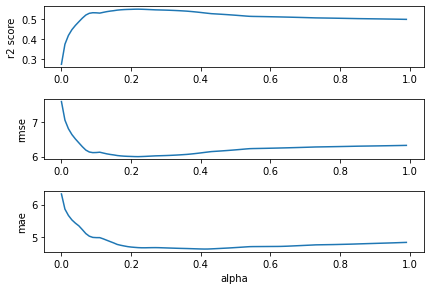

In [15]:
# find optimal alpha value
alphas = np.arange(0, 1, 0.01)
r2_scores = []
rmses = []
maes = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_val)
    r2_scores.append(r2_score(y_val, y_pred))
    rmses.append(rmse_func(lasso, X_val, y_val))
    maes.append(mean_absolute_error(y_pred, y_val))
    
fig, ax = plt.subplots(3, 1)
fig.tight_layout()
plt.xlabel('alpha')

ax[0].plot(alphas, r2_scores)
ax[0].set_ylabel('r2 score')

ax[1].plot(alphas, rmses)
ax[1].set_ylabel('rmse')

ax[2].plot(alphas, maes)
ax[2].set_ylabel('mae')

plt.show()

In [16]:
max_r2 = max(r2_scores)
max_index = r2_scores.index(max_r2)
best_alpha_r2 = alphas[max_index]

min_rmse = min(rmses)
min_index = rmses.index(min_rmse)
best_alpha_rmse = alphas[min_index]

min_mae = min(maes)
min_index = maes.index(min_mae)
best_alpha_mae = alphas[min_index]

print(best_alpha_r2, best_alpha_rmse, best_alpha_mae)

0.22 0.22 0.41000000000000003


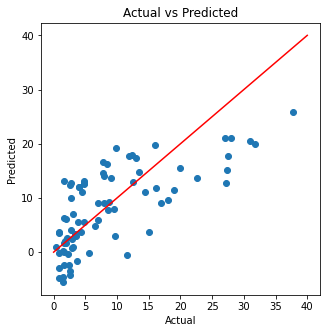

In [17]:
# Initiate and train the model
lasso = Lasso(alpha=0.22)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

# Visualize actual vs predicted salaries
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred)
plt.plot([0, 40], [0, 40], 'k-', c='r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [18]:
print('The r squared value is ' + str(r2_score(y_test, y_pred)))
print('The root mean square error is ' + str(rmse_func(lasso, X_test, y_test)))
print('The mean absolute error is ' + str(mean_absolute_error(y_pred, y_test)))

The r squared value is 0.4826548836674802
The root mean square error is 6.307662622259076
The mean absolute error is 5.118375654050387


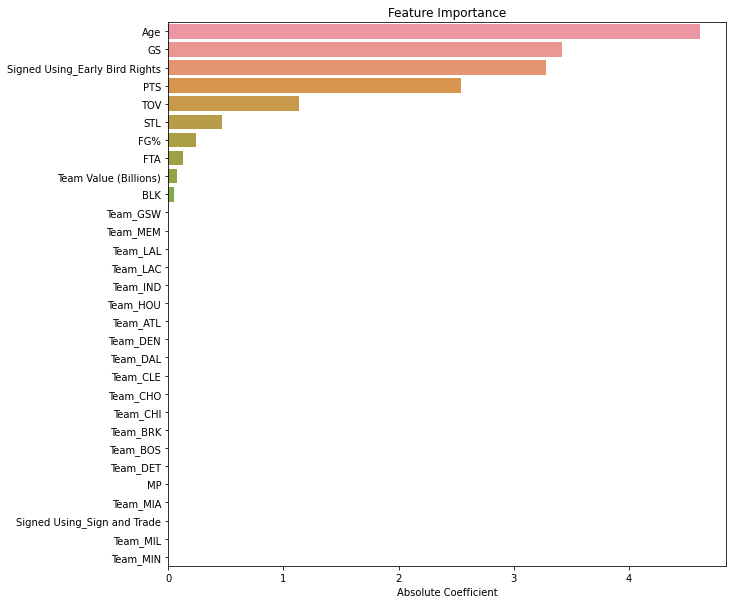

In [19]:
# Determine coefficients and create dataframe
coefs = lasso.coef_
columns = X_test.columns
importance = pd.DataFrame({'Absolute Coefficient': coefs})
importance.index = columns

# Sort by coefficient value and transpose
importance = importance.sort_values('Absolute Coefficient', ascending=False)
importance = importance.transpose()

# Define top 30 features
top_30 = importance.iloc[: , :30]

# Create a bar chart to show top 30 features 
plt.figure(figsize=(10,10))
sns.barplot(data=top_30, orient='h')
plt.xlabel('Absolute Coefficient')
plt.title('Feature Importance');

In general, none of the linear regression models perform very well with this dataset.  They all have somewhat weak r-squared values and high RMSE and MAE values relative to the range of salaries in the dataset.  Overall, the Ridge model was the best out of LinearRegression, Ridge, and Lasso models.  It had the highest r-squared and lowest rmse and mae values.

# KNN Regression

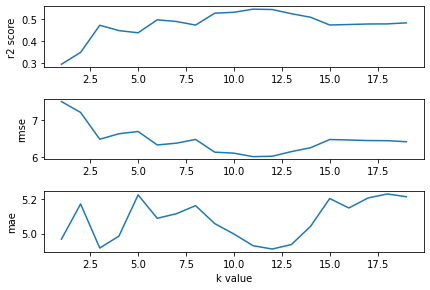

In [20]:
# optimize k
k_vals = np.arange(1, 20, 1)
r2_scores = []
rmses = []
maes = []

for k in k_vals:
    knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    r2_scores.append(r2_score(y_val, y_pred))
    rmses.append(rmse_func(knn, X_val, y_val))
    maes.append(mean_absolute_error(y_pred, y_val))
    
fig, ax = plt.subplots(3, 1)
fig.tight_layout()
plt.xlabel('k value')

ax[0].plot(k_vals, r2_scores)
ax[0].set_ylabel('r2 score')

ax[1].plot(k_vals, rmses)
ax[1].set_ylabel('rmse')

ax[2].plot(k_vals, maes)
ax[2].set_ylabel('mae')

plt.show()

In [21]:
max_r2 = max(r2_scores)
max_index = r2_scores.index(max_r2)
best_k_r2 = k_vals[max_index]

min_rmse = min(rmses)
min_index = rmses.index(min_rmse)
best_k_rmse = k_vals[min_index]

min_mae = min(maes)
min_index = maes.index(min_mae)
best_k_mae = k_vals[min_index]

print(best_k_r2, best_k_rmse, best_k_mae)

11 11 12


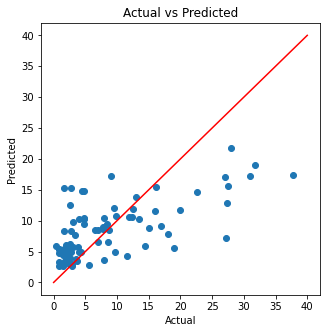

In [22]:
knn = KNeighborsRegressor(n_neighbors=11, weights='distance')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred)
plt.plot([0, 40], [0, 40], 'k-', c='r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [23]:
print('The r squared value is ' + str(r2_score(y_test, y_pred)))
print('The root mean square error is ' + str(rmse_func(knn, X_test, y_test)))
print('The mean absolute error is ' + str(mean_absolute_error(y_pred, y_test)))

The r squared value is 0.4143752573775885
The root mean square error is 6.711011576637508
The mean absolute error is 4.935241163919888


In [24]:
from sklearn.inspection import permutation_importance

# perform permutation importance
results = permutation_importance(knn, X_train, y_train, scoring='neg_mean_squared_error')

# get importance
importance = results.importances_mean

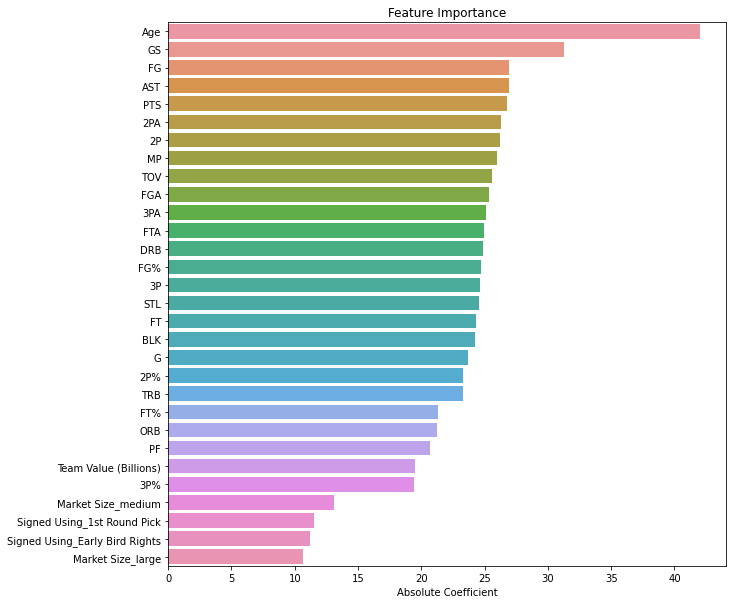

In [25]:
columns = X_test.columns
importance = pd.DataFrame({'Absolute Coefficient': importance})
importance.index = columns

# Sort by coefficient value and transpose
importance = importance.sort_values('Absolute Coefficient', ascending=False)
importance = importance.transpose()

# Define top 30 features
top_30 = importance.iloc[: , :30]

# Create a bar chart to show top 30 features 
plt.figure(figsize=(10,10))
sns.barplot(data=top_30, orient='h')
plt.xlabel('Absolute Coefficient')
plt.title('Feature Importance');

The KNN model is much better at predicting salaries in the lower range than the linear regression models.  There are no negative predicted salaries which is an improvement.  The KNN model is still not as good at predicting high salaries.  This is possibly because there are fewer datapoints as salary increases.  This KNN model was set up with n_neighbors=11 and trying to find 11 close neighbors for a highly paid (likely high performing) player is difficult.  It appears the the KNN model is relying more heavily on player stats than the previous models.  It is still not a great predictor, but it solved one of the problems that the linear regression models could not, the negative predictions.

# RandomForest

In [26]:
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [27]:
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# Use the random grid to search for best hyperparameters

# First create the base model to tune
rf = RandomForestRegressor(random_state=10)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=10, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=10),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=10, verbose=2)

In [28]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': True}

In [29]:
# Initiate model with best params and train
rf = RandomForestRegressor(n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features='auto', max_depth=90,
                           bootstrap=True, random_state=10)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

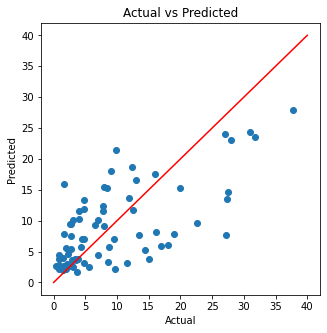

In [30]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred)
plt.plot([0, 40], [0, 40], 'k-', c='r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [31]:
print('The r squared value is ' + str(r2_score(y_test, y_pred)))
print('The root mean square error is ' + str(rmse_func(rf, X_test, y_test)))
print('The mean absolute error is ' + str(mean_absolute_error(y_pred, y_test)))

The r squared value is 0.47808267567021034
The root mean square error is 6.335474332446534
The mean absolute error is 4.757372590083698


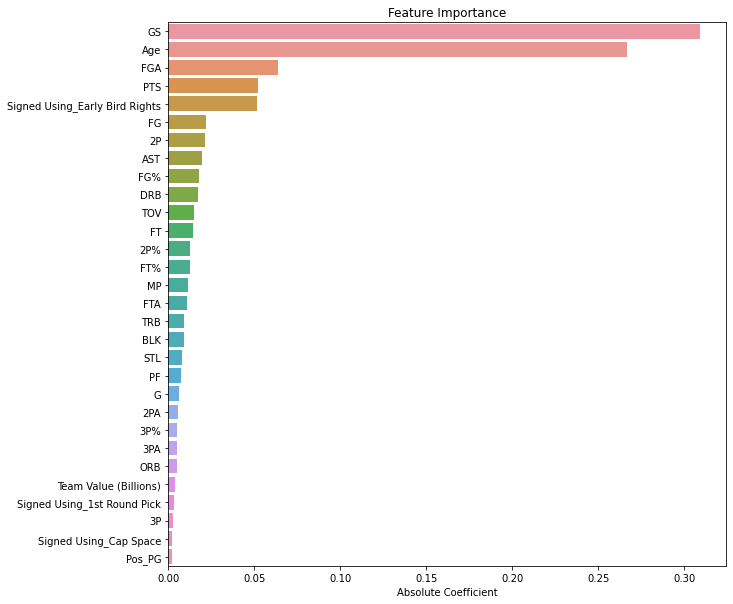

In [32]:
# Define feature importances
feat_imp = rf.feature_importances_
columns = X_test.columns
importance = pd.DataFrame({'Absolute Coefficient': feat_imp})
importance.index = columns

# Sort by coefficient value and transpose
importance = importance.sort_values('Absolute Coefficient', ascending=False)
importance = importance.transpose()

# Define top 30 features
top_30 = importance.iloc[: , :30]

# Create a bar chart to show top 30 features 
plt.figure(figsize=(10,10))
sns.barplot(data=top_30, orient='h')
plt.xlabel('Absolute Coefficient')
plt.title('Feature Importance');

# Results

The best model in terms of scoring metrics was the Ridge model.  It had the highest r-squared value (0.522), the lowest root mean squared error (6.063), and the lowest mean absolute error (4.724).

One problem with the linear regression, Ridge, and Lasso models is that there are negative predicted values.  This would mean that a player is paying his team to play, rather than getting paid.  Obviously this is not true so that is an issue in these models.

The random forest model and the KNN model did not predict any negative values, but also did not show great performance, especially when predicting higher salaries.  Both models tend to have lower predictions for the salaries that are actually very high. The random forest model can be considered better than the KNN model because it has a higher r-squared value, a lower root mean squared error value, and a lower mean absolute error value.  In a situation where more data was available, KNN might perform better becuase it would be expected that point clusters would be more dense and closer neighbors could be selected.

Overall, I would have to choose the random forest model as the best model, because it had similar r-squared, rmse, and mae values as the Ridge model, and it also did not predict any negative values.

For comparison (Ridge, Random Forest):  
r-squared: 0.522, 0.478  
rmse:  6.063, 6.335  
mae:  4.724, 4.757  